# Classify Spam using Adaboost and XGBoost



# Adaboost
For this exercise you will implement AdaBoost from scratch and applied it to a spam dataset. You will be classifying data into spam and not spam. You can call DecisionTreeClassifier from sklearn to learn your base classifiers.

Here is how you train a decision tree classifier with weights.

`
h = DecisionTreeClassifier(max_depth=1, random_state=0)
h.fit(X, Y, sample_weight=w)
`

Implementing AdaBoost with trees:

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [2]:
# accuracy computation
def accuracy(y, pred):
    return np.sum(y == pred) / float(len(y)) 

In [3]:
import pandas as pd
def parse_spambase_data(filename):
    """ Given a filename return X and Y numpy arrays

    X is of size number of rows x num_features
    Y is an array of size the number of rows
    Y is the last element of each row. (Convert 0 to -1)
    """
    # YOUR CODE HERE
    f = np.genfromtxt(filename,delimiter=',')
    X, Y = f[:,0:-1],f[:,-1]
    Y[Y==0]=-1
    return X, Y

In [4]:
y_test = np.array([1., -1., 1., 1., -1., -1., 1., 1., 1., -1.])
X, Y = parse_spambase_data("tiny.spam.train")
for i in range(len(y_test)): assert(y_test[i] == Y[i])
n, m = X.shape
assert(n == 10)
assert(m == 57)

In [5]:
def adaboost(X, y, num_iter):
    """Given an numpy matrix X, a array y and num_iter return trees and weights 
   
    Input: X, y, num_iter
    Outputs: array of trees from DecisionTreeClassifier
             trees_weights array of floats
    Assumes y is {-1, 1}
    """
    trees = []
    trees_weights = [] 
    N, _ = X.shape
    w = np.ones(N) / N
    # YOUR CODE HERE
    for i in range(num_iter):
        # fit and predict weak classifier h
        h = DecisionTreeClassifier(max_depth=1, random_state=0)
        h.fit(X, y, sample_weight=w)
        trees.append(h)
        pred = h.predict(X)
        # calculate error rate
        err = np.sum(w[y!=pred]) / np.sum(w)
        # calculate voting power
        if err > 0:
            E = (1-err) / err
            alpha = np.log(E)
            # update weight
            w[y!=pred] = w[y!=pred]*E
        else: # all predictions are correct 
            trees_weights.append(1)   
            return trees, trees_weights
        trees_weights.append(alpha)    
    return trees, trees_weights

In [6]:
X, Y = parse_spambase_data("tiny.spam.train")
trees, weights = adaboost(X, Y, 2)
assert(len(trees) == 2)
assert(len(weights) == 2)
assert(isinstance(trees[0], DecisionTreeClassifier))

In [7]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
h = trees[0]
pred = h.predict(x)
for i in range(len(y)): assert(pred[i] == y[i])

In [8]:
def adaboost_predict(X, trees, trees_weights):
    """Given X, trees and weights predict Y
    """
    # X input, y output
    #print(len(trees))
    N, _ =  X.shape
    y = np.zeros(N)
    for i in range(len(trees)):
        #print(trees_weights[i]*trees[i].predict(X))
        y += trees_weights[i]*trees[i].predict(X)
        
    y = np.sign(y)
    #y = list(map(int, y))
    return y

In [9]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
pred = adaboost_predict(x, trees, weights)
for i in range(len(y)):
    assert(pred[i] == y[i])

In [10]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")
trees, trees_weights = adaboost(X, Y, 10)
Yhat = adaboost_predict(X, trees, trees_weights)
Yhat_test = adaboost_predict(X_test, trees, trees_weights)
    
acc_test = accuracy(Y_test, Yhat_test)
acc_train = accuracy(Y, Yhat)
print("Train Accuracy %.4f" % acc_train)
print("Test Accuracy %.4f" % acc_test)
assert(np.around(acc_train, decimals=4)==0.9111)
assert(np.around(acc_test, decimals=4)==0.9190)

Train Accuracy 0.9111
Test Accuracy 0.9190


## Training with different number of trees

Apply AdaBoost to spambase dataset using different values
for the number of trees numTrees. Find the best value for
numTrees: Report train and validation accuracy for the best value
of numTrees. Make a plot that shows your experiment (training and
validation error as a function of the number of trees). 

In [11]:
%%time
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")
trees, trees_weights = adaboost(X, Y, 10000)


CPU times: user 53.1 s, sys: 323 ms, total: 53.5 s
Wall time: 53.9 s


### Error plots

In [12]:
def accuracy_graph(X, Y, X_val, Y_val, trees, trees_weights, interval = 50):
    """Given X, trees and weights predict Y
    """
    # X input, y output
    N, M =  X.shape[0],X_val.shape[0]
    #print(N, X.shape, X_val.shape)
    y = np.zeros(N)
    y_val = np.zeros(M)
    accuracy_rate_trn = []
    accuracy_rate_pred = []
    for i in range(len(trees)):
        y     += trees_weights[i]*trees[i].predict(X)
        y_val += trees_weights[i]*trees[i].predict(X_val)
        if (i+1) % interval == 0 and (i+1) >= 50: # min 50 trees
            accuracy_rate_trn.append(accuracy(Y, np.sign(y)))
            accuracy_rate_pred.append(accuracy(Y_val, np.sign(y_val)))
    return accuracy_rate_trn, accuracy_rate_pred, np.linspace(50,10000,int(9950/50)+1)

In [13]:
%%time
accuracy_rate_trn, accuracy_rate_pred, numTrees = accuracy_graph(X, Y, X_test, Y_test, trees, trees_weights)

CPU times: user 4.32 s, sys: 24.3 ms, total: 4.34 s
Wall time: 4.35 s


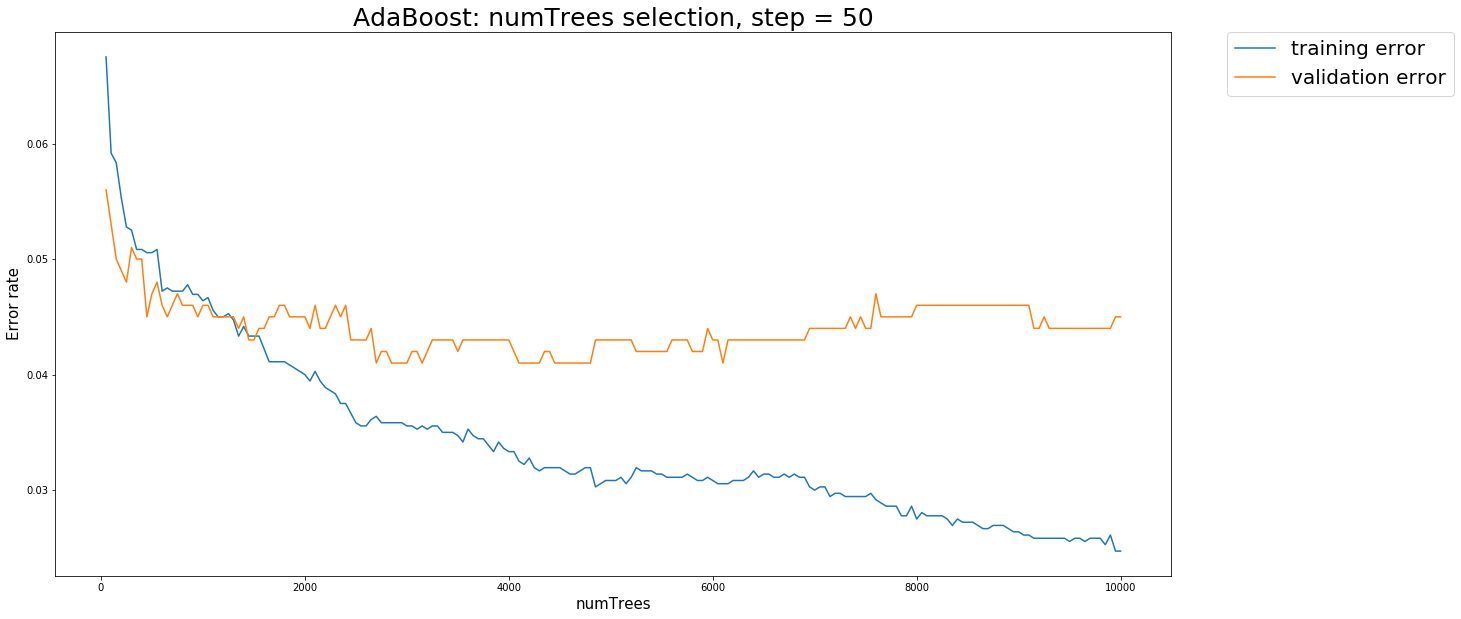

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.plot(numTrees, np.ones(len(accuracy_rate_trn))-accuracy_rate_trn,label='training error')
plt.plot(numTrees, np.ones(len(accuracy_rate_trn))-accuracy_rate_pred,label='validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.ylabel('Error rate',fontsize=15)
plt.xlabel('numTrees',fontsize=15)
plt.title('AdaBoost: numTrees selection, step = 50',fontsize=25)

plt.show()

In [15]:
# not unique select the least numTrees among them
sorted(accuracy_rate_pred, reverse=True)[:3]

[0.95899999999999996, 0.95899999999999996, 0.95899999999999996]

We plot the training error and validation error against the number of trees in the diagram above. By selecting different number of intervals between points, we see generally adaboost starts to overfit (training error decreases where validation error does not) after 'numTrees' is greater than **3000**. In the case interval = 50, the best number of trees is 2663.

In [16]:
best_idx = accuracy_rate_pred.index(max(accuracy_rate_pred))
best_numtrees = numTrees[best_idx]
print('best numTrees:', int(best_numtrees))
print('best validation error: %.4f' % (1-accuracy_rate_pred[best_idx]))
print('corresponding training error: %.4f' % (1-accuracy_rate_trn[best_idx]))

best numTrees: 2700
best validation error: 0.0410
corresponding training error: 0.0364


## XGBoost comparison

Compare your results with the results of running the gradient boosting package (XGBoost). Make a plot that shows the result of your experiments. Explore the hyper parameters given in the package.

In [17]:
import xgboost as xgb
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV

In [18]:
# Use (0,1) instead of (-1,+1) for prediction
Y = Y.clip(0,1)
Y_test = Y_test.clip(0,1)
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=Y)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [19]:
# Initialize some parameters to check the result
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_jobs':-1,
    'eval_metric':['error'],
    'objective': 'binary:logistic',
    }

watchlist = [(dtrain,'train'),(dtest,'eval')]
evals_result = {}

In [20]:
%%time
xgb0 = xgb.train(params, dtrain, num_boost_round=2000, evals=watchlist, obj=None, 
                feval=None, maximize=False, early_stopping_rounds=200, 
                evals_result=evals_result, verbose_eval=50, xgb_model=None, 
                callbacks=None)

# print('Access logloss metric directly from evals_result:')
# print(evals_result['eval']['error'])

[0]	train-error:0.105833	eval-error:0.098
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 200 rounds.
[50]	train-error:0.056944	eval-error:0.049
[100]	train-error:0.041667	eval-error:0.045
[150]	train-error:0.0325	eval-error:0.041
[200]	train-error:0.028056	eval-error:0.04
[250]	train-error:0.023056	eval-error:0.036
[300]	train-error:0.021389	eval-error:0.04
[350]	train-error:0.019167	eval-error:0.038
[400]	train-error:0.016667	eval-error:0.037
Stopping. Best iteration:
[246]	train-error:0.023889	eval-error:0.036

CPU times: user 7.46 s, sys: 909 ms, total: 8.37 s
Wall time: 1.42 s


### Parameter tunning
based on the blogs: 

- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://cambridgespark.com/content/tutorials/hyperparameter-tuning-in-xgboost/index.html

### General Approach for Parameter Tuning

- Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
- Lower the learning rate and decide the optimal parameters.

### Step1: Fix learning rate and number of estimators for tuning tree-based parameters

In [21]:
params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'n_jobs':-1,
    'eval_metric':['error'],
    'objective': 'binary:logistic',
    }

watchlist = [(dtrain,'train'),(dtest,'eval')]
evals_result = {}

In [22]:
xgb1 = xgb.train(params, dtrain, num_boost_round=2000, evals=watchlist, obj=None,
                 feval=None, maximize=False, early_stopping_rounds=200, 
                 evals_result=evals_result, verbose_eval=50, xgb_model=None, 
                 callbacks=None)

[0]	train-error:0.105833	eval-error:0.098
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 200 rounds.
[50]	train-error:0.067778	eval-error:0.056
[100]	train-error:0.056111	eval-error:0.051
[150]	train-error:0.048889	eval-error:0.049
[200]	train-error:0.043056	eval-error:0.045
[250]	train-error:0.037778	eval-error:0.04
[300]	train-error:0.033333	eval-error:0.043
[350]	train-error:0.029722	eval-error:0.042
[400]	train-error:0.028056	eval-error:0.042
Stopping. Best iteration:
[242]	train-error:0.038889	eval-error:0.04



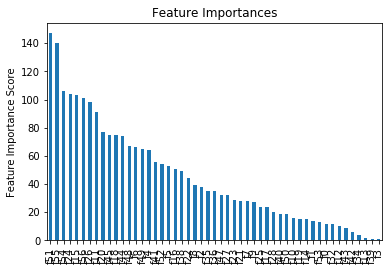

In [23]:
# Since the features are anonymous, it is not that important to see the relationship.
feat_imp = pd.Series(xgb1.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print()

### Step 2: Tune max_depth and min_child_weight

In [24]:
def xgboost_parameter_tuning(params, gridsearch_params, 
                             para_update, dtrain=dtrain, dtest=dtest, 
                             num_boost_round=2000, 
                             watchlist = [(dtrain,'train'),(dtest,'eval')], early_stop=300, 
                             evals_result=None, verbose=False):
    
    
    best_result = float("Inf")
    best_params = None 
    
    if type(gridsearch_params[0])==tuple:
        # grid_parameters at most 2 
        assert((len(gridsearch_params[0])<3))
        # grid_parameters combination should be greater than 1
        assert(len(gridsearch_params)>1)
        # grid_parameters should match the name
        assert(len(gridsearch_params[0])==len(para_update))
    
        # Tunning 2 parameters 
        if len(gridsearch_params[0]) == 2:
            for i, j in gridsearch_params:

                # Update our parameters
                params[para_update[0]] = i
                params[para_update[1]] = j

                # Train with updated params
                xgb1 = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=watchlist, obj=None,
                                 feval=None, maximize=False, early_stopping_rounds=early_stop, 
                                 evals_result=evals_result, verbose_eval=verbose, xgb_model=None, 
                                 callbacks=None)

                # Update best metric
                print("Tuning Parameters: "+para_update[0]+"={}\t".format(i)+para_update[1]+"={}".format(j)+
                      "\t validation " + params['eval_metric'][0]+ " {} for {} rounds".format(xgb1.best_score, xgb1.best_iteration))
                if xgb1.best_score < best_result:
                    best_result = xgb1.best_score
                    best_params = (i, j)

            print("\nBest params: "+para_update[0]+"={}, ".format(best_params[0])+
                  para_update[1]+"={}\t\t".format(best_params[1])+
                  params['eval_metric'][0]+": {}".format(best_result))
            params[para_update[0]] = best_params[0]
            params[para_update[1]] = best_params[1]
        
        
    # Tunning 1 parameter 
    if (type(gridsearch_params[0]) == float) or (type(gridsearch_params[0]) == int):
        for i in gridsearch_params:
            params[para_update[0]] = i
            
            # Train with updated params
            xgb1 = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=watchlist, obj=None,
                             feval=None, maximize=False, early_stopping_rounds=early_stop, 
                             evals_result=evals_result, verbose_eval=verbose, xgb_model=None, 
                             callbacks=None)
            
            # Update best metric
            print("Tuning Parameters: "+para_update[0]+"={}\t".format(i)+
                  "\t validation " + params['eval_metric'][0]+ " {} for {} rounds".format(xgb1.best_score, xgb1.best_iteration))
            if xgb1.best_score < best_result:
                best_result = xgb1.best_score
                best_params = i

        print("\nBest params: "+para_update[0]+"={}, ".format(best_params)+
              params['eval_metric'][0]+": {}".format(best_result))
        params[para_update[0]] = best_params
        
    print()
    print(params)
    return params

In [25]:
gridsearch_params = [(i, j) for i in [7,10, 12] for j in [.9,1,1.1]]
para_update = ['max_depth', 'min_child_weight']

params = xgboost_parameter_tuning(params=params, gridsearch_params=gridsearch_params, para_update=para_update)

Tuning Parameters: max_depth=7	min_child_weight=0.9	 validation error 0.036 for 290 rounds
Tuning Parameters: max_depth=7	min_child_weight=1	 validation error 0.037 for 307 rounds
Tuning Parameters: max_depth=7	min_child_weight=1.1	 validation error 0.038 for 320 rounds
Tuning Parameters: max_depth=10	min_child_weight=0.9	 validation error 0.032 for 209 rounds
Tuning Parameters: max_depth=10	min_child_weight=1	 validation error 0.032 for 262 rounds
Tuning Parameters: max_depth=10	min_child_weight=1.1	 validation error 0.034 for 268 rounds
Tuning Parameters: max_depth=12	min_child_weight=0.9	 validation error 0.033 for 220 rounds
Tuning Parameters: max_depth=12	min_child_weight=1	 validation error 0.033 for 335 rounds
Tuning Parameters: max_depth=12	min_child_weight=1.1	 validation error 0.035 for 206 rounds

Best params: max_depth=10, min_child_weight=0.9		error: 0.032

{'max_depth': 10, 'learning_rate': 0.05, 'n_jobs': -1, 'eval_metric': ['error'], 'objective': 'binary:logistic', 'min

### Step 3: Tune gamma

In [26]:
%%time
gridsearch_params = [i/10.0 for i in range(0,5)]
para_update = ['gamma']

params = xgboost_parameter_tuning(params=params, gridsearch_params=gridsearch_params, para_update=para_update)

Tuning Parameters: gamma=0.0		 validation error 0.032 for 209 rounds
Tuning Parameters: gamma=0.1		 validation error 0.032 for 238 rounds
Tuning Parameters: gamma=0.2		 validation error 0.032 for 232 rounds
Tuning Parameters: gamma=0.3		 validation error 0.034 for 226 rounds
Tuning Parameters: gamma=0.4		 validation error 0.035 for 274 rounds

Best params: gamma=0.0, error: 0.032

{'max_depth': 10, 'learning_rate': 0.05, 'n_jobs': -1, 'eval_metric': ['error'], 'objective': 'binary:logistic', 'min_child_weight': 0.9, 'gamma': 0.0}
CPU times: user 2min 23s, sys: 10.1 s, total: 2min 33s
Wall time: 23.4 s


### Step 4: Tune subsample and colsample_bytree

In [27]:
gridsearch_params = [(i, j) for i in [i/10.0 for i in range(7,10)] for j in [i/10.0 for i in range(7,10)]]
para_update = ['subsample', 'colsample_bytree']

params = xgboost_parameter_tuning(params=params, gridsearch_params=gridsearch_params, para_update=para_update)

Tuning Parameters: subsample=0.7	colsample_bytree=0.7	 validation error 0.033 for 386 rounds
Tuning Parameters: subsample=0.7	colsample_bytree=0.8	 validation error 0.034 for 389 rounds
Tuning Parameters: subsample=0.7	colsample_bytree=0.9	 validation error 0.035 for 336 rounds
Tuning Parameters: subsample=0.8	colsample_bytree=0.7	 validation error 0.032 for 138 rounds
Tuning Parameters: subsample=0.8	colsample_bytree=0.8	 validation error 0.035 for 73 rounds
Tuning Parameters: subsample=0.8	colsample_bytree=0.9	 validation error 0.033 for 191 rounds
Tuning Parameters: subsample=0.9	colsample_bytree=0.7	 validation error 0.032 for 195 rounds
Tuning Parameters: subsample=0.9	colsample_bytree=0.8	 validation error 0.033 for 434 rounds
Tuning Parameters: subsample=0.9	colsample_bytree=0.9	 validation error 0.034 for 273 rounds

Best params: subsample=0.8, colsample_bytree=0.7		error: 0.032

{'max_depth': 10, 'learning_rate': 0.05, 'n_jobs': -1, 'eval_metric': ['error'], 'objective': 'bina

### Step 5: Tuning Regularization Parameters

In [28]:
%%time
gridsearch_params = [0, 0.001, 0.005, 0.01, 0.05]
para_update = ['reg_alpha']

params = xgboost_parameter_tuning(params=params, gridsearch_params=gridsearch_params, para_update=para_update)

Tuning Parameters: reg_alpha=0		 validation error 0.032 for 138 rounds
Tuning Parameters: reg_alpha=0.001		 validation error 0.032 for 142 rounds
Tuning Parameters: reg_alpha=0.005		 validation error 0.032 for 141 rounds
Tuning Parameters: reg_alpha=0.01		 validation error 0.031 for 149 rounds
Tuning Parameters: reg_alpha=0.05		 validation error 0.033 for 175 rounds

Best params: reg_alpha=0.01, error: 0.031

{'max_depth': 10, 'learning_rate': 0.05, 'n_jobs': -1, 'eval_metric': ['error'], 'objective': 'binary:logistic', 'min_child_weight': 0.9, 'gamma': 0.0, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.01}
CPU times: user 1min 29s, sys: 8.77 s, total: 1min 38s
Wall time: 15.6 s


### Step 6: Tuning Learning Rate

In [29]:
%%time
gridsearch_params = [0.001, 0.01, 0.02, 0.03, 0.05, 0.1, 1]
para_update = ['learning_rate']

params = xgboost_parameter_tuning(params=params, gridsearch_params=gridsearch_params, para_update=para_update)


Tuning Parameters: learning_rate=0.001		 validation error 0.049 for 138 rounds
Tuning Parameters: learning_rate=0.01		 validation error 0.033 for 935 rounds
Tuning Parameters: learning_rate=0.02		 validation error 0.031 for 581 rounds
Tuning Parameters: learning_rate=0.03		 validation error 0.03 for 432 rounds
Tuning Parameters: learning_rate=0.05		 validation error 0.031 for 149 rounds
Tuning Parameters: learning_rate=0.1		 validation error 0.032 for 73 rounds
Tuning Parameters: learning_rate=1		 validation error 0.044 for 359 rounds

Best params: learning_rate=0.03, error: 0.03

{'max_depth': 10, 'learning_rate': 0.03, 'n_jobs': -1, 'eval_metric': ['error'], 'objective': 'binary:logistic', 'min_child_weight': 0.9, 'gamma': 0.0, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.01}
CPU times: user 3min 3s, sys: 19 s, total: 3min 22s
Wall time: 33.3 s


### Final result on validation set

In [30]:
bst = xgb.train(params, dtrain, num_boost_round=5000, evals=watchlist, obj=None,
                feval=None, maximize=False, early_stopping_rounds=500, 
                evals_result=evals_result, verbose_eval=100, xgb_model=None, 
                callbacks=None)

[0]	train-error:0.069444	eval-error:0.087
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 500 rounds.
[100]	train-error:0.018889	eval-error:0.038
[200]	train-error:0.011389	eval-error:0.037
[300]	train-error:0.005556	eval-error:0.034
[400]	train-error:0.003333	eval-error:0.033
[500]	train-error:0.001944	eval-error:0.032
[600]	train-error:0.001667	eval-error:0.032
[700]	train-error:0.001389	eval-error:0.035
[800]	train-error:0.001111	eval-error:0.034
[900]	train-error:0.001111	eval-error:0.035
Stopping. Best iteration:
[432]	train-error:0.002778	eval-error:0.03



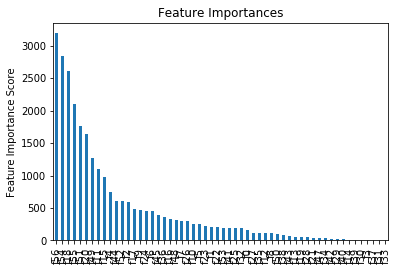

In [31]:
feat_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print()

**The validation error is 0.03 after parameter tunning, which is a significant improvement than Adaboost's best result which is 0.041.**